# Overview of triangulation precision dependencies

This research is a part of project "Handy" that is conducted by HSE Robotics Groups.
The aims of this research are the following:
- to determine the best placement of cameras around the table
- to measure precision fluctuations caused by various center-determing algorithms, segmentation errors and FOV

Let us assume that intrinsic parameters of the cameras are known to us with ideal precision. Also, cameras' positions relative to each other 
(parameters of stereo calibration) are also known with maximum precision.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.transform import Rotation
from scipy.ndimage import center_of_mass

from typing import Tuple, List

In [2]:
# let us introduce intrinsic parameters and assume that they provide zero reprojection error for an arbitrary image-world correlation

IMAGE_SIZE = (1200, 1920)
K_1 = np.array(
    [
        672.2824725267757,
        0,
        984.0472159818853,
        0,
        672.6886411532304,
        602.96669930345,
        0,
        0,
        1,
    ]
).reshape((3, 3))
distortion_coefs_1 = np.array(
    [
        -0.09715103386082896,
        0.06788948036532018,
        -0.0007157453506997161,
        0.0003048354358359307,
        -0.003636308978789861,
    ]
)
K_2 = np.array(
    [
        685.7143789189881,
        0,
        991.0247637161314,
        0,
        686.3020333004097,
        601.2442243349392,
        0,
        0,
        1,
    ]
).reshape((3, 3))
distortion_coefs_2 = np.array(
    [
        -0.09781628655937251,
        0.07153618281495966,
        -0.001066517414175782,
        0.0004679942401339674,
        -0.003645360450147547,
    ]
)
# reference:
# https://github.com/robotics-laboratory/handy/blob/table-dataset-1/datasets/TableOrange2msRecord_22_04/camera_params.yaml
stereo_cam_rotation = [0.01175419895518242, 2.170836441913732, 2.19333242876324]
stereo_cam_translation = [-0.06677747450343367, -1.174973690204363, 1.140354306665756]

# other constant and measurements
TABLE_LENGTH = 2.74
TABLE_WIDTH = 1.525

In [3]:
from typing import Any


class Transformation:
    def __init__(self, R, t):
        self.R = R
        self.t = t.reshape((3, 1))
        self.R_inv = np.linalg.inv(self.R)

    def __call__(self, point):
        return self.R @ point + self.t
    
    def __mul__(self, other):
        return Transformation(self.R @ other.R, self.R @ other.t + self.t)

    def transform(self, point):
        return self(point)

    def inverse_transform(self, point):
        return self.R_inv @ (point - self.t)

    # right transformation is applied first
    def __mult__(self, other):
        return Transformation(self.R @ other.R, self.t + other.t)
    

class Image:
    def __init__(self, camera_matrix, camera_transformation, distortion_coefs, image_size=IMAGE_SIZE):
        self.camera_matrix = camera_matrix
        self.camera_transformation = camera_transformation
        self.distortion_coefs = distortion_coefs
        self.image_size = image_size

    def normilise_image_point(self, point):
        x_normalised = (point[0] - self.camera_matrix[0, 2]) / self.camera_matrix[0, 0]
        y_normalised = (point[1] - self.camera_matrix[1, 2]) / self.camera_matrix[1, 1]
        return np.array([x_normalised, y_normalised, 1]).reshape(3, 1)

    # in world coordinates
    def project_point_to_image(self, point):
        transformed_point = self.camera_transformation(point)
        transformed_point = transformed_point / transformed_point[2]
        projected_point = self.camera_matrix @ transformed_point
        return projected_point
    
    def project_points_to_image(self, points):
        return np.array([self.project_point_to_image(point) for point in points])

    def project_ball_to_image(self, 
        center, radius: int) -> np.ndarray:
        center = center.reshape((3, 1))
        camera_matrix_inv = np.linalg.inv(self.camera_matrix)

        # projecting center and some edge point to approximate radius after projection
        projected_center = self.project_point_to_image(center)
        projected_center /= projected_center[2]
        edge_point = center + np.array([radius, 0, 0]).reshape((3, 1))
        projected_edge_point = self.project_point_to_image(edge_point)
        projected_edge_point /= projected_edge_point[2]
        approx_projected_radius = np.linalg.norm(
            projected_edge_point - projected_center, ord=2
        )

        # calculating bounding box for calculations with 1.5 margin
        x_start = int(max(0, projected_center[0].item() - 1.5 * approx_projected_radius))
        y_start = int(max(0, projected_center[1].item() - 1.5 * approx_projected_radius))
        x_stop = int(
            min(IMAGE_SIZE[1], projected_center[0].item() + 1.5 * approx_projected_radius)
        )
        y_stop = int(
            min(IMAGE_SIZE[0], projected_center[1].item() + 1.5 * approx_projected_radius)
        )

        image = np.zeros(self.image_size)
        for x in range(x_start, x_stop):
            for y in range(y_start, y_stop):
                # back project image point
                world_ray = camera_matrix_inv @ np.array([x, y, 1]).reshape((3, 1))
                # measure distance from the sphere center
                distance = np.linalg.norm(
                    np.cross(world_ray.flatten(), center.flatten()), ord=2
                ) / np.linalg.norm(world_ray, ord=2)
                # if back-projected ray intersects with the sphere, paint the pixel in the mask
                if distance <= radius:
                    image[y, x] = 1
        return image



Visually testing `Image` class

In [28]:
import plotly.graph_objects as go
import numpy as np

def display_plane(normal, size, origin):
    """Display a plane in the shape of a rectangle.
    
    Args:
        normal (tuple): Normal vector of the plane (nx, ny, nz).
        size (tuple): Size of the rectangle (width, height).
        origin (tuple): Origin of the rectangle (x, y, z).
    """
    normal = np.array(normal) / np.linalg.norm(normal)  # Normalize normal vector
    u = np.array([1, 0, 0]) if abs(normal[0]) < 0.9 else np.array([0, 1, 0])
    v = np.cross(normal, u)
    u = np.cross(v, normal)
    u, v = u / np.linalg.norm(u), v / np.linalg.norm(v)
    
    w, h = size
    corners = np.array([
        origin + w/2 * u + h/2 * v,
        origin - w/2 * u + h/2 * v,
        origin - w/2 * u - h/2 * v,
        origin + w/2 * u - h/2 * v,
    ])
    
    x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
    
    return go.Mesh3d(
        x=[*x, x[0]], y=[*y, y[0]], z=[*z, z[0]],
        color='lightblue', opacity=0.5, alphahull=0
    )

def display_ball(position, radius, color):
    """Display a ball (sphere).
    
    Args:
        position (tuple): (x, y, z) coordinates of the center.
        radius (float): Radius of the sphere.
        color (str): Color of the sphere.
    """
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = position[0] + radius * np.cos(u) * np.sin(v)
    y = position[1] + radius * np.sin(u) * np.sin(v)
    z = position[2] + radius * np.cos(v)
    
    return go.Surface(x=x, y=y, z=z, colorscale=[[0, color], [1, color]], showscale=False)

def display_parallelepiped(size, direction, origin=(0,0,0)):
    """Display a parallelepiped.
    
    Args:
        size (tuple): (width, height, depth).
        direction (tuple): A vector representing the "facing" direction.
        origin (tuple): Bottom-left corner of the parallelepiped.
    """
    direction = np.array(direction) / np.linalg.norm(direction)
    u = np.array([1, 0, 0]) if abs(direction[0]) < 0.9 else np.array([0, 1, 0])
    v = np.cross(direction, u)
    u = np.cross(v, direction)
    u, v = u / np.linalg.norm(u), v / np.linalg.norm(v)

    w, h, d = size
    corners = np.array([
        origin,
        origin + w * u,
        origin + h * v,
        origin + d * direction,
        origin + w * u + h * v,
        origin + w * u + d * direction,
        origin + h * v + d * direction,
        origin + w * u + h * v + d * direction
    ])
    
    x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]

    faces = [
        [0, 1, 4, 2],  # Bottom
        [0, 1, 5, 3],  # Side
        [1, 4, 7, 5],  # Side
        [2, 4, 7, 6],  # Side
        [0, 2, 6, 3],  # Side
        [3, 5, 7, 6]   # Top
    ]

    return go.Mesh3d(
        x=x, y=y, z=z,
        i=[face[0] for face in faces],
        j=[face[1] for face in faces],
        k=[face[2] for face in faces],
        color="orange", opacity=0.7
    )

def display_camera(position, direction, fov=60, aspect_ratio=1.5, depth=2.0, color="blue"):
    """
    Display a camera as a 3D pyramid.
    
    Args:
        position (tuple): (x, y, z) world position of the camera.
        direction (tuple): (dx, dy, dz) unit vector pointing in the direction of the camera.
        fov (float): Field of view in degrees (controls the width of the base).
        aspect_ratio (float): Aspect ratio (width/height of base).
        depth (float): Depth of the pyramid (distance from camera to base).
        color (str): Color of the camera pyramid.
    """
    # Normalize the direction vector
    direction = np.array(direction) / np.linalg.norm(direction)

    # Compute right and up vectors to construct the base
    up = np.array([0, 0, 1]) if abs(direction[2]) < 0.9 else np.array([1, 0, 0])
    right = np.cross(direction, up)
    up = np.cross(right, direction)
    
    right = right / np.linalg.norm(right)
    up = up / np.linalg.norm(up)

    # Compute base size using FOV
    angle = np.radians(fov / 2)
    base_half_width = np.tan(angle) * depth
    base_half_height = base_half_width / aspect_ratio

    # Compute base corners
    base_center = position + depth * direction
    corners = np.array([
        base_center + base_half_width * right + base_half_height * up,
        base_center - base_half_width * right + base_half_height * up,
        base_center - base_half_width * right - base_half_height * up,
        base_center + base_half_width * right - base_half_height * up,
    ])
    
    # Pyramid vertices
    vertices = np.vstack([position, corners])

    # Pyramid faces (indices)
    faces = [
        [0, 1, 2],  # Side 1
        [0, 2, 3],  # Side 2
        [0, 3, 4],  # Side 3
        [0, 4, 1],  # Side 4
        [1, 2, 3, 4]  # Base
    ]

    # Create Mesh3D
    camera_mesh = go.Mesh3d(
        x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
        i=[face[0] for face in faces],
        j=[face[1] for face in faces],
        k=[face[2] for face in faces],
        color=color, opacity=0.5
    )

    # Create direction line
    direction_line = go.Scatter3d(
        x=[position[0], base_center[0]],
        y=[position[1], base_center[1]],
        z=[position[2], base_center[2]],
        mode="lines",
        line=dict(color=color, width=4),
        name="Camera Direction"
    )

    return [camera_mesh, direction_line]

# # Create figure
# fig = go.Figure()

# # Add two cameras
# fig.add_traces(display_camera(position=(0, 0, 1), direction=(1, 1, -0.2), fov=60, color="red"))
# fig.add_traces(display_camera(position=(2, 2, 1), direction=(-1, -1, -0.2), fov=45, color="blue"))

# fig.update_layout(scene=dict(aspectmode="data"))
# fig.show()

# # Create figure
# fig = go.Figure()

# # Add plane
# fig.add_trace(display_plane((0, 0, 1), (2, 1), (0, 0, 0)))

# # Add ball
# fig.add_trace(display_ball((0.5, 0.5, 0.5), 0.2, "red"))

# # Add parallelepiped
# fig.add_trace(display_parallelepiped((1, 0.5, 0.3), (1, 1, 1), (1, 1, 0)))

# fig.update_layout(scene=dict(aspectmode="data"))
# fig.show()


In [37]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px

class StereoScene:
    def __init__(self, left_camera: Image, right_camera: Image):
        self.left_camera = left_camera
        self.right_camera = right_camera

    def project_ball_to_images(self, center, radius):
        left_image = self.left_camera.project_ball_to_image(center, radius)
        right_image = self.right_camera.project_ball_to_image(center, radius)
        return left_image, right_image
    
    def launch_3D_scene(self):
        app = dash.Dash(__name__)

        app.layout = html.Div([
            dcc.Graph(id='3d-scene'),
            dcc.Graph(id='left-image'),
            dcc.Graph(id='right-image'),
            html.Label('Ball X Position'),
            dcc.Slider(id='ball-x', min=-2, max=2, step=0.05, value=0),
            html.Label('Ball Y Position'),
            dcc.Slider(id='ball-y', min=-2, max=2, step=0.05, value=0),
            html.Label('Ball Z Position'),
            dcc.Slider(id='ball-z', min=0, max=3, step=0.05, value=1),
        ])

        @app.callback(
            [Output('3d-scene', 'figure'),
             Output('left-image', 'figure'),
             Output('right-image', 'figure')],
            [Input('ball-x', 'value'),
             Input('ball-y', 'value'),
             Input('ball-z', 'value')]
        )
        def update_scene(ball_x, ball_y, ball_z):
            ball_center = np.array([ball_x, ball_y, ball_z]).reshape((3, 1))
            left_image, right_image = self.project_ball_to_images(ball_center, 0.04)
            
            fig_3d = go.Figure()
            fig_3d.add_trace(display_plane((0, 0, 1), (TABLE_LENGTH, TABLE_WIDTH), (0, 0, 0)))
            fig_3d.add_trace(display_ball((ball_x, ball_y, ball_z), 0.04, "green"))

            fig_3d.add_trace(go.Cone(x=[0], y=[0], z=[0], u=[0], v=[0], w=[1], showscale=False, 
                                     sizemode="absolute", sizeref=0.1, anchor="tip", colorscale=[[0, "red"], [1, "red"]]))

            second_camera_direction = self.right_camera.camera_transformation(np.array([0, 0, 1])).flatten().tolist()
            fig_3d.add_trace(go.Cone(x=[0], y=[0], z=[0], u=[second_camera_direction[0]], v=[second_camera_direction[1]], w=[second_camera_direction[2]], 
                                     sizemode="absolute", sizeref=0.1, anchor="tip",
                                     colorscale=[[0, "blue"], [1, "blue"]]))
            
            fig_left = go.Figure(data=go.Heatmap(z=left_image))
            fig_right = go.Figure(data=go.Heatmap(z=right_image))
            
            return fig_3d, fig_left, fig_right

        return app

    # def project_points_to_image(self, points):
    #     return self.left_camera.project_points_to_image(points), self.right_camera.project_points_to_image(points)

    # def project_point_to_image(self, point):
    #     return self.left_camera.project_point_to_image(point), self.right_camera.project_point_to_image(point)

    # def project_point_to_world(self, left_point, right_point):
    #     left_point = self.left_camera.camera_transformation.inverse_transform(left_point)
    #     right_point = self.right_camera.camera_transformation.inverse_transform(right_point)
    #     return left_point, right_point

    # def project_points_to_world(self, left_points, right_points):
    #     return self

In [40]:
camera_1_transform = Transformation(np.eye(3), np.array([0, 0, 0]))
image_1 = Image(K_1, camera_1_transform, distortion_coefs_1)
camera_2_transform = Transformation(cv2.Rodrigues(np.array(stereo_cam_rotation))[0], 
                                    np.array(stereo_cam_translation))
image_2 = Image(K_2, camera_2_transform, distortion_coefs_2)

scene = StereoScene(image_1, image_2)
app = scene.launch_3D_scene()
app.run_server(host="localhost", port="8060",
               debug=True, use_reloader=False)

In [24]:
import plotly.graph_objects as go
from IPython.display import display, clear_output

camera_1_transform = Transformation(np.eye(3), np.array([0, 0, 0]))
image_1 = Image(K_1, camera_1_transform, distortion_coefs_1)
camera_2_transform = Transformation(np.eye(3), np.array([0, 0, 0]))
# Transformation(cv2.Rodrigues(np.array(stereo_cam_rotation))[0], 
#                                     np.array(stereo_cam_translation))
image_2 = Image(K_2, camera_2_transform, distortion_coefs_2)



ball_center = np.array([0, 0, 5]).reshape((3, 1))
image_with_ball = image_1.project_ball_to_image(ball_center, 0.25)



In [14]:
np.array([1, 0, 0]).reshape((3, 1))

array([[1],
       [0],
       [0]])

In [97]:
def validate_image_point(point):
    return (
        point[0] < 0
        or point[0] >= IMAGE_SIZE[0]
        or point[1] < 0
        or point[1] >= IMAGE_SIZE[1]
    )
    # raise ValueError(f"Invalid image point coordinates: out of FOV?")


def project_point_to_image(point, transformation, camera_matrix):
    return camera_matrix @ transformation(point)


def normilise_image_point(point, camera_matrix):
    x_normalised = (point[0] - camera_matrix[0, 2]) / camera_matrix[0, 0]
    y_normalised = (point[1] - camera_matrix[1, 2]) / camera_matrix[1, 1]
    return np.array([x_normalised, y_normalised, 1]).reshape(3, 1)


def project_sphere_to_image(
    center, radius: int, camera_matrix: np.ndarray, world2cam
) -> np.ndarray:
    image = np.zeros(IMAGE_SIZE[::-1])
    center = center.reshape((3, 1))
    camera_matrix_inv = np.linalg.inv(camera_matrix)

    # projecting center and some edge point to approximate radius after projection
    projected_center = project_point_to_image(center, world2cam, camera_matrix)
    projected_center /= projected_center[2]
    edge_point = center + np.array([radius, 0, 0]).reshape((3, 1))
    projected_edge_point = project_point_to_image(edge_point, world2cam, camera_matrix)
    projected_edge_point /= projected_edge_point[2]
    approx_projected_radius = np.linalg.norm(
        projected_edge_point - projected_center, ord=2
    )

    # calculating bounding box for calculations with 1.5 margin
    x_start = int(max(0, projected_center[0].item() - 1.5 * approx_projected_radius))
    y_start = int(max(0, projected_center[1].item() - 1.5 * approx_projected_radius))
    x_stop = int(
        min(IMAGE_SIZE[0], projected_center[0].item() + 1.5 * approx_projected_radius)
    )
    y_stop = int(
        min(IMAGE_SIZE[1], projected_center[1].item() + 1.5 * approx_projected_radius)
    )

    for x in range(x_start, x_stop):
        for y in range(y_start, y_stop):
            # back project image point
            world_ray = camera_matrix_inv @ np.array([x, y, 1]).reshape((3, 1))
            # measure distance from the sphere center
            distance = np.linalg.norm(
                np.cross(world_ray.flatten(), center.flatten()), ord=2
            ) / np.linalg.norm(world_ray, ord=2)
            # if back-projected ray intersects with the sphere, paint the pixel in the mask
            if distance <= radius:
                image[y, x] = 1
    return image


# image = project_sphere_to_image((-0.25, 0.25, 0.5), 0.02, K_1, None)
# plt.imshow(image, cmap="gray")
# plt.show()

In [76]:
def triangulate_position(
    points_by_view, world2cam, cam2cam, camera_matrix_1, camera_matrix_2
):
    world2cam_Rt = np.column_stack((world2cam.R, world2cam.t))
    world2second_cam = cam2cam * world2cam
    world2second_cam_Rt = np.column_stack((world2second_cam.R, world2second_cam.t))
    proj_1 = camera_matrix_1 @ world2cam_Rt
    proj_2 = camera_matrix_2 @ world2second_cam_Rt
    # TODO preserve 4D points?
    res = cv2.triangulatePoints(
        proj_1, proj_2, points_by_view[:, :, 0].T, points_by_view[:, :, 1].T
    )
    for i in range(res.shape[1]):
        res[:, i] /= res[3, i]
    return res[:3, :]

In [95]:
def get_bbox(mask: np.ndarray) -> List[float]:
    if not np.any(mask):
        return [0., 0., 0., 0.]
    # x_min, y_min, x_max, y_max
    horizontal_indicies = np.where(np.any(mask, axis=0))[0]
    vertical_indicies = np.where(np.any(mask, axis=1))[0]
    x1, x2 = horizontal_indicies[[0, -1]]
    y1, y2 = vertical_indicies[[0, -1]]
    bbox = list(map(float, [x1, y1, x2, y2]))
    return bbox


def get_mask_center(mask):
    bbox = get_bbox(mask)
    centroid_x = (bbox[0] + bbox[2]) / 2
    centroid_y = (bbox[1] + bbox[3]) / 2
    return np.array([centroid_x, centroid_y])


def get_mask_centroid(mask):
    return np.array(center_of_mass(mask))

In [107]:
def evaluate_precision(sphere_centers, triangulated_points):
    print(sphere_centers[:, :5])
    print(triangulated_points[:, :5])
    errors = sphere_centers - triangulated_points
    print("precision of triangulated points:")
    print(np.mean(errors * errors))

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(sphere_centers[0, :], sphere_centers[1, :], sphere_centers[2, :], marker='o')
    ax.scatter(triangulated_points[0, :], triangulated_points[1, :], triangulated_points[2, :], marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

0
20
40
60
80
100
120
triangulated_points shape is (3, 125)
[[-1.37    -0.7625   0.      -1.37    -0.7625 ]
 [ 0.25    -0.685    0.38125  0.5     -0.685  ]
 [-0.38125  0.75     0.685   -0.38125  1.     ]]
[[ 1.29940542  1.29940542  1.29940542  1.29940542  1.29940542]
 [ 1.03681671  1.03681671  1.03681671  1.03681671  1.03681671]
 [-1.40207606 -1.40207606 -1.40207606 -1.40207606 -1.40207606]]
precision of triangulated points:
2.744184139499578


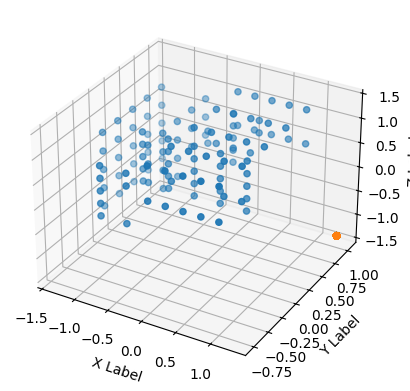

evalution complete


In [114]:
def evaluate_camera_position(
    world2master: Transformation,
    master2second: Transformation,
    center_extranctor,
    camera_matrix_1,
    camera_matrix_2,
):
    NUMBER_OF_SPHERES = 5
    sphere_centers = []
    for x in np.linspace(-TABLE_LENGTH / 2, TABLE_LENGTH / 2, NUMBER_OF_SPHERES):
        for y in np.linspace(-TABLE_WIDTH / 2, TABLE_WIDTH / 2, NUMBER_OF_SPHERES):
            for z in np.linspace(0, 1, NUMBER_OF_SPHERES):
                sphere_centers.append((x, y, z))
    sphere_centers = np.array(sphere_centers).reshape((3, NUMBER_OF_SPHERES**3))
    points = []
    world2second = master2second * world2master
    for i in range(sphere_centers.shape[1]):
        if i % 20 == 0:
            print(i)
        mask_1 = project_sphere_to_image(
            sphere_centers[:, i : (i + 1)], 0.02, K_1, world2master
        )
        mask_2 = project_sphere_to_image(
            sphere_centers[:, i : (i + 1)], 0.02, K_2, world2second
        )
        points.append((center_extranctor(mask_1), center_extranctor(mask_2)))
    triangulated_points = triangulate_position(
        np.array(points), world2master, master2second, camera_matrix_1, camera_matrix_2
    )
    print(f"triangulated_points shape is {triangulated_points.shape}")

    evaluate_precision(sphere_centers, triangulated_points)
    print("evalution complete")


# main test: opposite camera placement
# world2master = Transformation(Rotation.from_euler("xyz", [0, -45, -90], degrees=True).as_matrix(), np.array([-TABLE_LENGTH/4, TABLE_WIDTH, 0.5]))
# master2second = Transformation(Rotation.from_euler("xyz", [], degrees=True).as_matrix(), np.array([0, 0, 0]))

world2master = Transformation(
    Rotation.from_euler("xyz", [0, -45, -90], degrees=True).as_matrix(),
    np.array([-TABLE_LENGTH / 4, TABLE_WIDTH, 0.5]),
)
master2second = Transformation(
    Rotation.from_euler(
        "xyz", [0.01175419895518242, 2.170836441913732, 2.19333242876324], degrees=False
    ).as_matrix(),
    np.array([-0.06677747450343367, -1.174973690204363, 1.140354306665756]),
)
evaluate_camera_position(world2master, master2second, get_mask_center, K_1, K_2)

In [1]:
import plotly.graph_objects as go

fig = go.Figure()

# Add a table (as a plane)
fig.add_trace(go.Mesh3d(x=[0, 1, 1, 0], y=[0, 0, 1, 1], z=[0, 0, 0, 0], color='lightblue', opacity=0.50))

# Add some spheres (balls)
import numpy as np
def create_sphere(center, radius, color):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = center[0] + radius * np.cos(u) * np.sin(v)
    y = center[1] + radius * np.sin(u) * np.sin(v)
    z = center[2] + radius * np.cos(v)
    return go.Surface(x=x, y=y, z=z, colorscale=[[0, color], [1, color]])

fig.add_trace(create_sphere([0.5, 0.5, 0.5], 0.1, 'red'))
fig.add_trace(create_sphere([0.7, 0.3, 0.2], 0.1, 'blue'))

fig.show()


In [2]:
import plotly.graph_objects as go
import numpy as np

def display_plane(normal, size, origin):
    """Display a plane in the shape of a rectangle.
    
    Args:
        normal (tuple): Normal vector of the plane (nx, ny, nz).
        size (tuple): Size of the rectangle (width, height).
        origin (tuple): Origin of the rectangle (x, y, z).
    """
    normal = np.array(normal) / np.linalg.norm(normal)  # Normalize normal vector
    u = np.array([1, 0, 0]) if abs(normal[0]) < 0.9 else np.array([0, 1, 0])
    v = np.cross(normal, u)
    u = np.cross(v, normal)
    u, v = u / np.linalg.norm(u), v / np.linalg.norm(v)
    
    w, h = size
    corners = np.array([
        origin + w/2 * u + h/2 * v,
        origin - w/2 * u + h/2 * v,
        origin - w/2 * u - h/2 * v,
        origin + w/2 * u - h/2 * v,
    ])
    
    x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]
    
    return go.Mesh3d(
        x=[*x, x[0]], y=[*y, y[0]], z=[*z, z[0]],
        color='lightblue', opacity=0.5, alphahull=0
    )

def display_ball(position, radius, color):
    """Display a ball (sphere).
    
    Args:
        position (tuple): (x, y, z) coordinates of the center.
        radius (float): Radius of the sphere.
        color (str): Color of the sphere.
    """
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = position[0] + radius * np.cos(u) * np.sin(v)
    y = position[1] + radius * np.sin(u) * np.sin(v)
    z = position[2] + radius * np.cos(v)
    
    return go.Surface(x=x, y=y, z=z, colorscale=[[0, color], [1, color]], showscale=False)

def display_parallelepiped(size, direction, origin=(0,0,0)):
    """Display a parallelepiped.
    
    Args:
        size (tuple): (width, height, depth).
        direction (tuple): A vector representing the "facing" direction.
        origin (tuple): Bottom-left corner of the parallelepiped.
    """
    direction = np.array(direction) / np.linalg.norm(direction)
    u = np.array([1, 0, 0]) if abs(direction[0]) < 0.9 else np.array([0, 1, 0])
    v = np.cross(direction, u)
    u = np.cross(v, direction)
    u, v = u / np.linalg.norm(u), v / np.linalg.norm(v)

    w, h, d = size
    corners = np.array([
        origin,
        origin + w * u,
        origin + h * v,
        origin + d * direction,
        origin + w * u + h * v,
        origin + w * u + d * direction,
        origin + h * v + d * direction,
        origin + w * u + h * v + d * direction
    ])
    
    x, y, z = corners[:, 0], corners[:, 1], corners[:, 2]

    faces = [
        [0, 1, 4, 2],  # Bottom
        [0, 1, 5, 3],  # Side
        [1, 4, 7, 5],  # Side
        [2, 4, 7, 6],  # Side
        [0, 2, 6, 3],  # Side
        [3, 5, 7, 6]   # Top
    ]

    return go.Mesh3d(
        x=x, y=y, z=z,
        i=[face[0] for face in faces],
        j=[face[1] for face in faces],
        k=[face[2] for face in faces],
        color="orange", opacity=0.7
    )

# Create figure
fig = go.Figure()

# Add plane
fig.add_trace(display_plane((0, 0, 1), (2, 1), (0, 0, 0)))

# Add ball
fig.add_trace(display_ball((0.5, 0.5, 0.5), 0.2, "red"))

# Add parallelepiped
fig.add_trace(display_parallelepiped((1, 0.5, 0.3), (1, 1, 1), (1, 1, 0)))

fig.update_layout(scene=dict(aspectmode="data"))
fig.show()
